In [54]:
import os
import csv
import configparser

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.ticker import FixedLocator, FuncFormatter, StrMethodFormatter
from scipy.stats import linregress

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['text.usetex'] = True

In [ ]:
prefix = "./executed/helena/CUHK-SE-Group-TrainTicket_PPTAM_31-03-2025/executed"
prefix = "/Users/ajanes/Documents/code/pptam/pptam-rejuvenation/helena/test_CUHK-SE-Group-train_ticket_PPTAM_results_13.11.22h06/executed"
prefix_for_plots = "trainticket-CUHK-SE"

experiment_folders = sorted([name for name in os.listdir(prefix) if os.path.isdir(os.path.join(prefix, name))])

load_values = {}  

for folder in experiment_folders:
    config_path = os.path.join(prefix, folder, "configuration.ini")

    config = configparser.ConfigParser()
    config.read(config_path)
    load_value = config['CONFIGURATION']['LOAD']
    load_values[folder] = load_value

print("\nCollected load values:")
for folder, load in load_values.items():
    print(f"{folder} ({load} users)")


Collected load values:
202411132208-tt-test1 (1 users)
202411132228-tt-test2 (5 users)
202411132248-tt-test3 (10 users)
202411132308-tt-test4 (15 users)
202411132328-tt-test5 (20 users)
202411132348-tt-test6 (25 users)


In [56]:
endpoints = set()

for folder in experiment_folders:
    csv_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} does not exist, skipping.")
        continue

    with open(csv_path, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            name = row['Name']
            if name != "Aggregated" and name != "":
                endpoints.add(name)

endpoints = sorted(endpoints)

print("\nUnique API endpoints found:")
for name in endpoints:
    print(f"- {name}")


Unique API endpoints found:
- /api/v1/adminuserservice/users
- /api/v1/assuranceservice/assurances/types
- /api/v1/contactservice/contacts
- /api/v1/contactservice/contacts/account/user
- /api/v1/executeservice/execute/collected/order
- /api/v1/executeservice/execute/execute/order
- /api/v1/foodservice/foods/departure/shanghai/suzhou/D1345
- /api/v1/inside_pay_service/inside_payment
- /api/v1/orderservice/order/refresh
- /api/v1/preserveservice/preserve
- /api/v1/travelservice/trips/left
- /api/v1/users/login
- /index.html


In [57]:
endpoint_requirements = {}

for endpoint in endpoints:
    found = False
    for folder in experiment_folders:
        csv_path = os.path.join(prefix, folder, "result_stats.csv")
        
        if not os.path.exists(csv_path):
            continue

        with open(csv_path, 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Name'] == endpoint:
                    avg_response = float(row['Average Response Time'])
                    percentile_75 = float(row['75%'])
                    percentile_25 = float(row['25%'])

                    # Approximate standard deviation from IQR
                    iqr = percentile_75 - percentile_25
                    stddev = iqr / 1.35

                    # Calculate requirement
                    requirement = avg_response + 3 * stddev

                    endpoint_requirements[endpoint] = {
                        'Average Response Time': avg_response,
                        'Standard deviation': stddev,
                        'Requirement': requirement
                    }

                    found = True
                    break  # Found it, no need to search more
        if found:
            break

df = pd.DataFrame.from_dict(endpoint_requirements, orient='index')
df = df.reset_index().rename(columns={'index': 'Endpoint'})
df = df[['Endpoint', 'Average Response Time', 'Standard deviation', 'Requirement']]
df = df.round({
    'Average Response Time': 2,
    'Standard deviation': 2,
    'Requirement': 2
})

# Add line number starting from 1
df.insert(0, 'No.', range(1, len(df) + 1))

print("\nCalculated Requirements:")
display(df)


Calculated Requirements:


,No.,Endpoint,Average Response Time,Standard deviation,Requirement
0,1,/api/v1/adminuserservice/users,203.82,0.00,203.82
1,2,/api/v1/assuranceservice/assurances/types,9.32,1.48,13.76
2,3,/api/v1/contactservice/contacts,49.33,0.00,49.33
3,4,/api/v1/contactservice/contacts/account/user,11.75,2.22,18.41
4,5,/api/v1/executeservice/execute/collected/order,22.03,2.96,30.92
5,6,/api/v1/executeservice/execute/execute/order,21.76,2.22,28.43
6,7,/api/v1/foodservice/foods/departure/shanghai/s...,43.43,4.44,56.76
7,8,/api/v1/inside_pay_service/inside_payment,52.58,6.67,72.58
8,9,/api/v1/orderservice/order/refresh,14.49,3.70,25.60
9,10,/api/v1/preserveservice/preserve,344.33,22.22,410.99


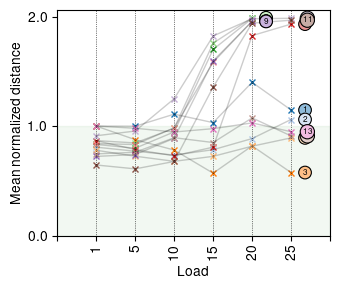

In [62]:
requirements = [endpoint_requirements[ep]['Requirement'] for ep in endpoints]

fig_width = 3.5
fig_height = 3
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

mark_coords = {}

cmap = colormaps.get_cmap('tab20') # or 'tab10', 'Set3', etc.
endpoint_colors = {ep: cmap(i) for i, ep in enumerate(endpoints)}

def brighten_color(color, factor=0.5):
    r, g, b, a = color
    r = r + (1.0 - r) * factor
    g = g + (1.0 - g) * factor
    b = b + (1.0 - b) * factor
    return (r, g, b, 1.0)  # Force alpha = 1

endpoint_background_colors = {ep: brighten_color(color) for ep, color in endpoint_colors.items()}

for experiment_number, folder in enumerate(experiment_folders, start=1):
    file_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(file_path):
        continue

    data = pd.read_csv(file_path, delimiter=",", decimal=".")
    
    for i, endpoint in enumerate(endpoints):
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            mean = float(row['Average Response Time'])
            ndist = (2 * mean) / (mean + requirements[i])

            # ax.plot(experiment_number, ndist, marker='x', markersize=4, color="steelblue")
            ax.plot(experiment_number, ndist, marker='x', markersize=4, color=endpoint_colors[endpoint], alpha=1)

            if endpoint not in mark_coords:
                mark_coords[endpoint] = []
            mark_coords[endpoint].append((experiment_number, ndist))

last_ndist_values = {endpoint: points[-1][1] for endpoint, points in mark_coords.items()}

ax.set_title("")
ax.set_xlabel('Load')
ax.set_ylabel('Mean normalized distance')
ax.set_yscale("linear") #linear, log, symlog, logit
ax.set_ylim(0, None)
ax.set_xlim(0, len(experiment_folders) + 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))

def my_formatter(x, pos):
    x = int(x)
    if x < 1 or x > len(experiment_folders):
        return ""
    folder = experiment_folders[x-1]

    load = load_values[folder]
    return load

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

# Draw lines between points for each endpoint
for index, (endpoint, points) in enumerate(mark_coords.items()):
    points = sorted(points)
    x_vals, y_vals = zip(*points)
    ax.plot(x_vals, y_vals, color='black', alpha=0.2, linewidth=1)

    # Add index as the label near the last point
    last_x, last_y = points[-1]

    ax.text(last_x + 0.3, last_y, str(index + 1), fontsize=6, verticalalignment='center', bbox=dict(boxstyle="circle", fc=endpoint_background_colors[endpoint], ec="black", lw=0.8))

x_values = np.array(ax.get_xlim())
y_value = 1
ax.fill_between(x_values, y_value, color='green', alpha=0.05)

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-nd.pdf")
plt.show()


In [63]:
endpoint_slopes = {}

for endpoint in endpoints:
    loads = []
    max_response_times = []
    
    for folder in experiment_folders:
        file_path = os.path.join(prefix, folder, "result_stats.csv")
        
        if not os.path.exists(file_path):
            continue

        data = pd.read_csv(file_path, delimiter=",", decimal=".")
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            max_response_time = float(row['Max Response Time'])
            load = int(load_values[folder])

            loads.append(load)
            max_response_times.append(max_response_time)

    if len(loads) >= 2:
        slope, intercept, r_value, p_value, std_err = linregress(loads, max_response_times)
        endpoint_slopes[endpoint] = float(slope)
    else:
        endpoint_slopes[endpoint] = None  # not enough data to fit

slope_data = []
for endpoint, slope in endpoint_slopes.items():
    if slope is not None:
        slope_data.append({"Endpoint": endpoint, "Slope": f"{slope:.2f}"})
    else:
        slope_data.append({"Endpoint": endpoint, "Slope": "Not enough data"})

slope_df = pd.DataFrame(slope_data)
display(slope_df)


,Endpoint,Slope
0,/api/v1/adminuserservice/users,18.08
1,/api/v1/assuranceservice/assurances/types,-0.05
2,/api/v1/contactservice/contacts,0.56
3,/api/v1/contactservice/contacts/account/user,0.45
4,/api/v1/executeservice/execute/collected/order,14376.43
5,/api/v1/executeservice/execute/execute/order,14513.48
6,/api/v1/foodservice/foods/departure/shanghai/s...,1132.74
7,/api/v1/inside_pay_service/inside_payment,14326.35
8,/api/v1/orderservice/order/refresh,1070.29
9,/api/v1/preserveservice/preserve,11726.85


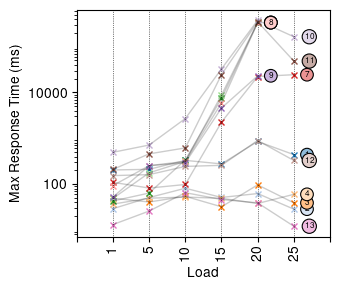

In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator, FuncFormatter, StrMethodFormatter
import matplotlib.font_manager as fm

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

mark_coords = {}

for experiment_number, folder in enumerate(experiment_folders, start=1):
    file_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(file_path):
        continue

    data = pd.read_csv(file_path, delimiter=",", decimal=".")

    for i, endpoint in enumerate(endpoints):
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            max_response_time = float(row['Max Response Time'])

            ax.plot(experiment_number, max_response_time, marker='x', markersize=4, color=endpoint_colors[endpoint], alpha=1)

            if endpoint not in mark_coords:
                mark_coords[endpoint] = []
            mark_coords[endpoint].append((experiment_number, max_response_time))

# Set axis properties
ax.set_title("")
ax.set_xlabel('Load')
ax.set_ylabel('Max Response Time (ms)')
ax.set_yscale("log")
# ax.set_ylim(0, None)
ax.set_xlim(0, len(experiment_folders) + 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))

def my_formatter(x, pos):
    x = int(x)
    if x < 1 or x > len(experiment_folders):
        return ""
    folder = experiment_folders[x-1]
    load = load_values[folder]
    return load

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

# Draw lines between points for each endpoint
for index, (endpoint, points) in enumerate(mark_coords.items()):
    points = sorted(points)
    x_vals, y_vals = zip(*points)
    
    # Plot connecting lines
    ax.plot(x_vals, y_vals, color='black', alpha=0.2, linewidth=1)

    # Add small index label near the last point
    last_x, last_y = x_vals[-1], y_vals[-1]

    ax.text(last_x + 0.3, last_y, str(index + 1), fontsize=6, verticalalignment='center', bbox=dict(boxstyle="circle", fc=endpoint_background_colors[endpoint], ec="black", lw=0.8))

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-max_response_times.pdf")
plt.show()


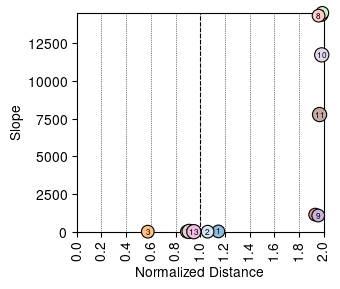

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

endpoints = list(last_ndist_values.keys())
x_vals = [last_ndist_values[ep] for ep in endpoints]
y_vals = [endpoint_slopes[ep] for ep in endpoints]

for idx, (x, y) in enumerate(zip(x_vals, y_vals), start=1):
    endpoint = endpoints[idx - 1]  # Get the correct endpoint
    ax.text(
        x, y, str(idx),
        fontsize=6, va='center', ha='center',
        bbox=dict(
            boxstyle="circle",
            fc=endpoint_background_colors[endpoint],  # dynamic face color
            ec="black", lw=0.8
        )
    )

ax.axvline(x=1, color='black', linestyle='--', linewidth=0.8)

ax.set_title("")
ax.set_xlabel('Normalized Distance')
ax.set_ylabel('Slope')

ax.set_yscale("linear")
ax.set_ylim(0, max(endpoint_slopes.values()))
ax.set_xlim(0, 2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2))

def my_formatter(x, pos):
    return f"{x:.1f}"

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-slope-vs-nd.pdf")
plt.show()
